<a href="https://colab.research.google.com/github/astralcai/music-genre-classification/blob/master/music_classification_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import sys
import time
import pickle
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report 
from sklearn.metrics import precision_score , recall_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt 
import tensorflow as tf

# Preprocess the dataset and split the dataset if necessary
def preprocess(gtzan_spectrograms, gtzan_labels):
    # Training dataset 
    trainingData = gtzan_spectrograms
    # Training dataset label
    label = gtzan_labels
    one_hot_label = []
    # Change the dataset label to one-hot vector
    for k in label:
        # The first label stands for music genre - "blues"
        if k == 0:
            one_hot_label.append([1, 0, 0, 0, 0])
        # The second label stands for music genre - "hiphop"
        if k == 1:
            one_hot_label.append([0, 1, 0, 0, 0])
        # The third label stands for music genre - "jazz"
        if k == 2:
            one_hot_label.append([0, 0, 1, 0, 0])
        # The fourth label stands for music genre - "pop"
        if k == 3:
            one_hot_label.append([0, 0, 0, 1, 0])
        # The fifth label stands for music genre - "rock"
        if k == 4:
            one_hot_label.append([0, 0, 0, 0, 1])
    # Reserve 80% for training dataset, 10% for validation dataset, 10% for testing dataset
    x_train, x_validation, y_train, y_validation = train_test_split(trainingData, one_hot_label,train_size=3669, test_size=408,shuffle=True)
    x_test, x_validation, y_test, y_validation = train_test_split(x_validation,y_validation, train_size=204, test_size=204, shuffle=True)
    test_label = []
    for i in list(y_test):
        # The first label stands for music genre - "blues"
        if i == [1, 0, 0, 0, 0]:
            test_label.append(0)
        # The second label stands for music genre - "hiphop"
        if i == [0, 1, 0, 0, 0]:
            test_label.append(1)
        # The third label stands for music genre - "jazz"
        if i == [0, 0, 1, 0, 0]:
            test_label.append(2)
        # The fourth label stands for music genre - "pop"
        if i == [0, 0, 0, 1, 0]:
            test_label.append(3)
        # The fifth label stands for music genre - "rock"
        if i == [0, 0, 0, 0, 1]:
            test_label.append(4)

    x_train = np.array(x_train)
    x_validation = np.array(x_validation)
    x_test = np.array(x_test)
    y_train = np.array(y_train)
    y_validation = np.array(y_validation)
    y_test = np.array(y_test)
    return x_train, y_train, x_validation, y_validation, x_test, y_test,test_label

# Use the following to load spectrograms:
# modify name_suffix to choose dataset
name_suffix = '_3_1024'
gtzan_spectrograms = pickle.load(open('drive/My Drive/mgc_dataset/gtzan_spectrograms' + name_suffix + '.p', 'rb'))
gtzan_labels = pickle.load(open('drive/My Drive/mgc_dataset/gtzan_labels'+ name_suffix + '.p', 'rb'))

x_train, y_train, x_validation, y_validation, x_test, y_test,test_label = preprocess(gtzan_spectrograms, gtzan_labels)
x_train = np.expand_dims(x_train, -1)
x_validation = np.expand_dims(x_validation, -1)
x_test = np.expand_dims(x_test, -1)
input_shape = (513, 128, 1)

# Five possible output music genre types
num_category = 5
model = Sequential()
# First convolutional layer using relu as the activation function
model.add(layers.Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
# Then downsampling the feature maps
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# Second convolutional layer using relu as the activation function
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# Then downsampling the feature maps
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# Flatten the output from convolutional layer to one dimensional array
model.add(layers.Flatten())
# Pass the one dimensional array to the denselu fully connected layer
model.add(layers.Dense(128, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(num_category, activation='softmax'))
# Use the Adam as the optimizer and use categorical_crossentropy 
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy',tf.keras.metrics.AUC()])
# Stop training the model if the accuracy over the validation set does not make any improvement for 5 consecutive
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Train the model
history =model.fit(x_train, y_train, batch_size=16, epochs=20, validation_data=(x_validation, y_validation), callbacks=[callback])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 3669 samples, validate on 204 samples
Epoch 1/20
3669/3669 [==============================] - 231s 63ms/sample - loss: 1.3653 - acc: 0.5004 - auc: 0.8097 - val_loss: 1.1015 - val_acc: 0.6520 - val_auc: 0.8988
Epoch 2/20
3669/3669 [==============================] - 225s 61ms/sample - loss: 1.0746 - acc: 0.6751 - auc: 0.9061 - val_loss: 0.9787 - val_acc: 0.7353 - val_auc: 0.9334
Epoch 3/20
3669/3669 [==============================] - 225s 61ms/sample - loss: 0.9322 - acc: 0.7700 - auc: 0.9476 - val_loss: 1.0244 - val_acc: 0.7745 - val_auc: 0.9391
Epoch 4/20
3669/3669 [==============================] - 225s 61ms/sample - loss: 0.9125 - acc: 0.8119 - auc: 0.9618 - val_loss: 1.0913 - val_acc: 0.7941 - val_auc: 0.9377
Epoch 5/20
3669/3669 [==============================] - 224s 61ms/sample - loss: 0.7962 - acc: 0.8594 - auc: 0.9763 - val_loss: 1.1092 - val_acc: 0.8088 - val_auc: 0.9424
Epoch 6/20
3669/3

204/204 [==============================] - 3s 14ms/sample - loss: 1.0630 - acc: 0.7255 - auc: 0.9164
Test score: 1.0629844852522308
Test accuracy: 0.7254902
Test AUC 0.91635126
Testing dataset confusion matrix: 
 [[17  2  8  0  7]
 [ 0 32  1  1  2]
 [ 1  0 40  0  4]
 [ 1  6  3 30  8]
 [ 1  7  4  0 29]]
Testing dataset Accuracy Score: 
 0.7254901960784313
Testing dataset Report : 
               precision    recall  f1-score   support

           0       0.85      0.50      0.63        34
           1       0.68      0.89      0.77        36
           2       0.71      0.89      0.79        45
           3       0.97      0.62      0.76        48
           4       0.58      0.71      0.64        41

    accuracy                           0.73       204
   macro avg       0.76      0.72      0.72       204
weighted avg       0.76      0.73      0.72       204



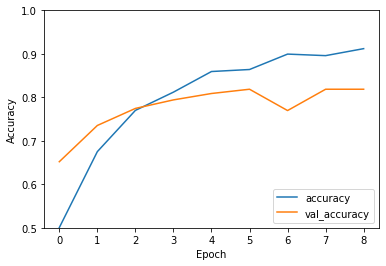

In [3]:
# Test the accuracy over the testing dataset
score, acc, auc= model.evaluate(x_test, y_test)
print('Test score:', score)
print('Test accuracy:', acc)
print('Test AUC', auc)
# Plot the graph of the training data accuracy and validation accuracy
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# Evaluate the data set.
predictTesting = model.predict_classes(np.asarray(x_test))
# Print the testing dataset confusion matrix and testing dataset report
print("Testing dataset confusion matrix: \n", confusion_matrix(test_label, predictTesting))
print('Testing dataset Accuracy Score: \n', accuracy_score(test_label, predictTesting))
print('Testing dataset Report : \n', classification_report(test_label, predictTesting))